___

# M915 - Συστήματα Κατανόησης και Παραγωγής Κειμένου 
___
### Kylafi Christina-Theano <br><br> LT1200012

In [7]:
# imports
# essentials
import os
import random
import numpy as np
from numpy import mean, std
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
from collections import Counter
import re, string, unicodedata
import pickle 
from datetime import datetime
import pytz
from itertools import cycle
from scipy import interp 
import time
import copy
import json
import csv
from ast import literal_eval

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset

# SKLEARN
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, OneHotEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, log_loss, plot_confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import utils
from sklearn.svm import SVC

# NLTK
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

import ast
!pip install datasets
from datasets import load_metric

# BERT
# !pip install transformers
# !pip install pytorch-pretrained-bert

import transformers
from transformers.data.processors.squad import SquadV2Processor
from transformers.data import squad_convert_examples_to_features
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertModel, BertForPreTraining, BertTokenizerFast, AdamW, BertForQuestionAnswering, DistilBertTokenizer, DistilBertForQuestionAnswering, DistilBertTokenizerFast, DistilBertModel
from torch.utils.data import DataLoader
from transformers import AdamW
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

import warnings

# MORE INSTALLATIONS & IMPORTS
# !pip install yellowbrick
# !pip install advertools
# !pip install vaderSentiment
# !pip install ekphrasis
# !pip install tweet-preprocessor

from wordcloud import WordCloud
# import advertools as adv
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from ekphrasis.classes.segmenter import Segmenter
# import preprocessor as p
import multiprocessing
from shutil import copy
import seaborn as sns
from gensim.models import Word2Vec
from IPython.display import Image
from ast import literal_eval
from tqdm.notebook import tqdm
from IPython.display import FileLink, FileLinks

print("\nImports Done !\n")

# Device settings
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Working on {device}")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Imports Done !

Working on cuda


In [22]:
# Functions
def squad_df(file_path, record_path=['data','paragraphs','qas','answers']):
    file = json.loads(open(file_path).read())
    
    # parsing different level's in the json file
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file,record_path[:-2])
    
    # combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id','context','question','answers']].set_index('id').reset_index()
    data['context_id'] = data['context'].factorize()[0]
    return data


# Add answer end index
def add_ans_ind(qna_df):
    texts = qna_df["context"]
    answers = qna_df["answers"]
    for row,(text,answers) in enumerate(zip(texts,answers)):
        for a_num,a in enumerate(answers):
            a_text = a["text"]
            a_start = a["answer_start"]
            a_end = a_start
            
            a_end = int(a_start+len(a_text))
            if text[a_start:a_end] == a_text:
                qna_df.loc[row,"answers"][a_num]["answer_end"]=a_end
            else:
                if a_start==0:
                    continue
                else:
                    if a_start==1:
                        if text[a_start-1:a_end-1] == a_text:
                            qna_df.loc[row,"answers"][a_num]["answer_start"]= a_start - 1
                            qna_df.loc[row,"answers"][a_num]["answer_end"]= a_end - 1

                    else:
                        if text[a_start-2:a_end-2] == a_text:
                            qna_df.loc[row,"answers"][a_num]["answer_start"]= a_start - 2
                            qna_df.loc[row,"answers"][a_num]["answer_end"]= a_end - 2

           
    return qna_df

def add_token_positions(encodings, texts, starts, ends):
    # initialize lists to contain the token indices of answer start/end
    start_pos = []
    end_pos = []
    unanswerable_pos = tokenizer.model_max_length
    for i,(text,start,end) in enumerate( zip(texts,starts,ends) ):
        # unanswerable questions
        if start==end==len(text):
            start_pos.append(unanswerable_pos)
            end_pos.append(unanswerable_pos)
            continue
        else:
            start_pos.append(encodings.char_to_token(i, start))
            end_pos.append(encodings.char_to_token(i, end))
            if start_pos[-1] is None:
                start_pos[-1] = unanswerable_pos
                end_pos[-1] = unanswerable_pos
                continue
           
            shift = 1
            while end_pos[-1] is None and end-shift>start:
                end_pos[-1] = encodings.char_to_token(i, end - shift)
                shift += 1
            if end_pos[-1] is None:
                start_pos[-1] = unanswerable_pos
                end_pos[-1] = unanswerable_pos

    encodings.update({'start_positions': start_pos, 'end_positions': end_pos})

# apply function to our data
# add_token_positions(dev_encodings, list(qna_dev_df['AnswerStart']), list(qna_dev_df['AnswerEnd']))


def save_json_evalsquad1(total_preds,filepath="preds.json", dev_set="/content/dev-v2.0.json"):
    with open(filepath, "w") as outfile:
        json.dump(ast.literal_eval(json.dumps(total_preds)), outfile)
    
#     !python3 /content/evaluate-v2.0.py {dev_set} {filepath}
    !python3 /kaggle/input/bert-code/bert/evaluate.py {dev_set} {filepath} 

    
def get_prediction(qid,total_preds):
    return total_preds[qid]

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re

    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_exact_match(prediction, truth):
    return int(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)



def get_gold_answers(qid,id_to_answers):
    
    gold_answers = [answer["text"] for answer in id_to_answers[qid] if answer["text"]]

    # if gold_answers doesn't exist it's because this is a negative example - 
    # the only correct answer is an empty string
    if not gold_answers:
        gold_answers = [""]
    
    return gold_answers

def evalEMandF1_squad1(dev_df,total_preds):
    global id_to_answers
    questions = [  q for q in dev_df["question"].values  ]
    id_s = [ i for i in dev_df["id"].values ]
    answer_s = [ ans for ans in dev_df["answers"].values ]
    
#     id_to_answers = {k:v for k,v in zip(id_s,answer_s)}
    em_score = []
    f1_score = []

#   logfile for predictions and true answers
    logfile_name = "best_model_preds.txt"
    logfile_path = os.path.join( os.path.join("./Results/Logfiles"),logfile_name)
    logfile = open(logfile_path, "w", encoding="utf-8")
    logfile.write("Best Model Question Predictions on Dev Set\n")
    for num,(qid,quest) in enumerate(zip(id_s,questions)):
        prediction = get_prediction(qid,total_preds)
        true_answers = get_gold_answers(qid,id_to_answers)

        em_score.append(max((compute_exact_match(prediction, answer)) for answer in true_answers))
        f1_score.append(max((compute_f1(prediction, answer)) for answer in true_answers))
        
        log_str = f"\n\n{num+1}. Question: {quest}\nTrue Answer(s): {true_answers}\nPrediction(s): {prediction}\nEM: {bool(int(em_score[-1]))}\nF1: {f1_score[-1]*100:.2f}%"
        logfile.write(log_str)
    
    logfile.close()
    
    em = sum(em_score)/len(id_s)*100
    f1_mean = sum(f1_score)/len(id_s)*100
    f1_max = max(f1_score)*100
    score_str = f"Dev Set Scores -- \tEM: {em:.2f}% \tF1 (mean): {f1_mean:.2f}% \tF1 (max): {f1_max:.2f}%\n"
    print(score_str)
    return em,f1_mean,f1_max,score_str


def total_preds_list(model,dev_dataset,device,dev_df):
    global id_to_answers
    model.to(device)
    model.eval()
    # initialize list to store epoch accuracies

    total_preds = {}
    acc = []
    gtruth = {}
    predictions = {}

    batch_size=64
    val_loader = DataLoader(dev_dataset, batch_size=batch_size)
    id_list = [ i for i in dev_df["id"].values ]
    batch_sizes= [ len(val_b["input_ids"]) for val_b in val_loader]
    batches=len(val_loader)
    id_loader = [ id_list[i*batch_size:i*batch_size+batch_size] for i in range(batches-1) ]
    id_loader.append([ id_list[- batch_sizes[-1] :] ])
#     print(id_loader, batch_sizes, batches)

    # create a dictionary to link question id's with answers
    questions = [  q for q in dev_df["question"].values  ]
#     id_list = [ i for i in dev_df["id"].values ]
    answer_s = [ ans for ans in dev_df["answers"].values ]
    
    loss_dev = 0
    loop_dev = tqdm(val_loader,leave=True)
    for batch,ids in zip(val_loader, id_loader):
        # we don't need to calculate gradients as we're not training
        with torch.no_grad():
            # pull batched items from loader
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # we will use true positions for accuracy calc
    #         start_true = batch['start_positions'].to(device)
    #         end_true = batch['end_positions'].to(device)
            qid = ids
            # make predictions
            outputs = model(input_ids, attention_mask=attention_mask)
#             loss = outputs[0]
#             loss_dev += loss.item()
    #         print(outputs['start_logits'])
            # pull prediction tensors out and argmax to get predicted tokens
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)

    #         ans_pred_list = [ (question_id,p) for question_id,p in zip(qid,preds) ]
            preds = [ tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[num][start_pred[num]:end_pred[num]])) for num in range(len(qid)) ]
            total_preds.update({ q:pred for q,pred in zip(qid,preds) })
            
            loop_dev.update(1)

    return total_preds


def log_model(logfile,datetime_info,model,model_name,loss_func,optimizer,batch_size,normalization,max_s_len,pretrained):
    separator = "".join([ "_" for i in range(50) ])
    logstring = ""

    # logstring+= f"\n\n\n\n{separator}\n{separator}\n\n"
    logstring+= f"{datetime_info} - {model_name}\n\n"
    logstring+= f"Features: {model.embedding.embedding_dim}\n"
    logstring+= f"Max Sentence length: {max_s_len}\n"
    logstring+= f"Pretrained Embeddings: {pretrained}\n"
    logstring+= f"Normalization: {normalization}\n"
    # logstring+= f"Epochs: {epochs}\n"
    logstring+= f"Batch size: {batch_size}\n"
    logstring+= f"Optimizer: {optimizer}\n"
    logstring+= f"Loss function: {loss_func}"
    if type(loss_func) == torch.nn.CrossEntropyLoss:
        logstring+= f", weight: {loss_func.weight}\n"
    else :
        logstring+= "\n"
        logstring+= f"Layers: {model}\n\n"
        logstring+= f"{separator}\n\n"

    logfile.write(logstring)


def log_score(logfile,epoch,model,score_str):
    separator = "".join([ "_" for i in range(50) ])
    logstring = ""

    logstring+= f"\n\n\n> Epoch:{epoch}\n"
    logstring+= score_str


    logfile.write(logstring)


# Logfiles
def get_file_ptr(drive_path,model_name):
    tz = pytz.timezone('Europe/Athens')
    datetime_info = f"{datetime.now(tz):%d%m%y_%H%M}"

    logfile_name = f"{model_name}__{datetime_info}.txt"
    model_logfile_dir_path = os.path.join(drive_path, f"Results/Logfiles/{logfile_name[:-4]}") 
    if not os.path.exists(model_logfile_dir_path):
        os.makedirs(model_logfile_dir_path)  

    logfile_path = os.path.join( os.path.join(model_logfile_dir_path),logfile_name)
    logfile = open(logfile_path, "w", encoding="utf-8")

    return logfile, datetime_info, model_logfile_dir_path, logfile_path


def log_model_bert(logfile,datetime_info,model_name,optimizer,batch_size,max_s_len,train_len,val_len):
    separator = "".join([ "_" for i in range(50) ])
    logstring = ""

    # logstring+= f"\n\n\n\n{separator}\n{separator}\n\n"
    logstring+= f"{datetime_info} - {model_name}\n\n"
    logstring+= f"Max Sentence length: {max_s_len}\n"
    logstring+= f"Batch size: {batch_size}\n"
    logstring+= f"Optimizer: {optimizer}\n"
    logstring+= f"Training Data: {train_len}\n"
    logstring+= f"Validation Data: {val_len}\n"
    #   logstring+= f"Layers: {model}\n\n"
    logstring+= f"{separator}\n\n"

    logfile.write(logstring)
  


def data_stats(df, type="Train"):
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    enc = tokenizer(list(df['context']), max_length=tokenizer.model_max_length, truncation=False )
    lens=[ len(i_id) for i_id in enc["input_ids"] ]
    print(max(lens))
    plt.figure(figsize=(18,12))
    plt.grid(True)
    plt.hist(lens)

    return lens


# pr_list = add_ans_ind(qna_train_df_quac)
# pr_list = add_ans_ind(qna_dev_df_quac)

In [10]:
# directories' paths
squad_train_path = "/kaggle/input/bert-code/bert/train-v1.1.json"
squad_dev_path = "/kaggle/input/bert-code/bert/dev-v1.1.json"
train_df = squad_df(squad_train_path)
dev_df = squad_df(squad_dev_path)

results_path = "/kaggle/working/results"
if not os.path.exists(results_path):
    os.makedirs(results_path)
    
eval_v1_path = "/kaggle/input/bert-code/bert/evaluate.py"
eval_v2_path = "/kaggle/input/httpsgithubcomsomiltgbert/evaluate-v2.0.py"

In [11]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df = train_df[: int(train_df.shape[0]/5)]
print(train_df.shape)

(17545, 5)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


512


92.15161014534056

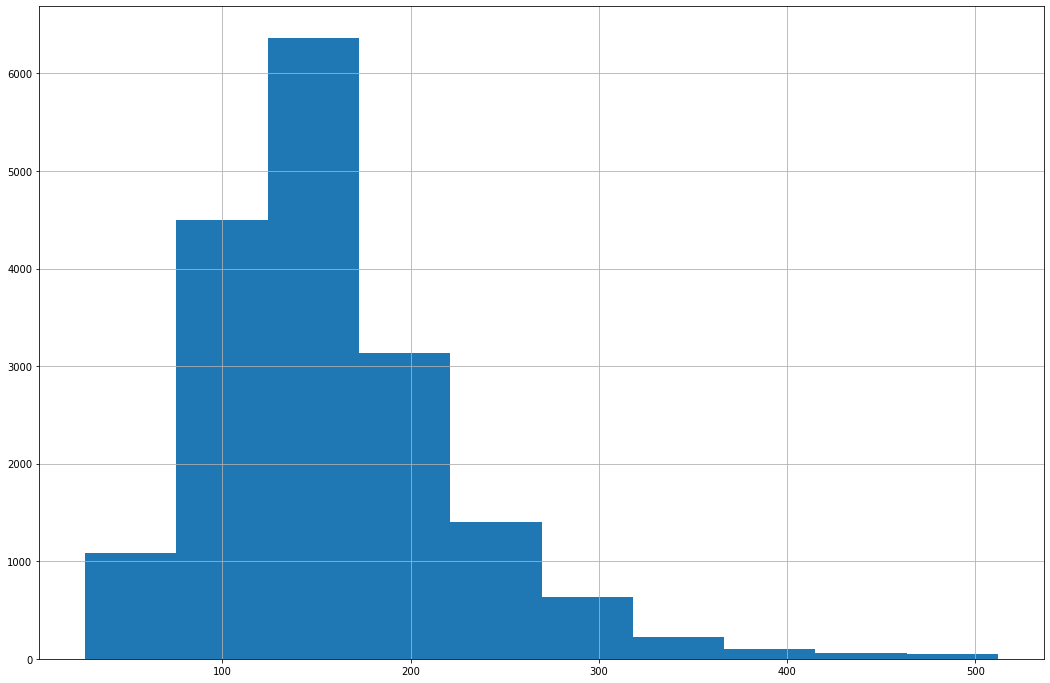

In [14]:
lens = data_stats(train_df)
sum([i<256 for i in lens])/len(lens)*100

In [16]:
# clean GPU cache
import gc
import torch
def clean_GPU_cache(print_sum=False):
    if print_sum:  
        print("\nBefore\n")
        print(torch.cuda.memory_summary(device=device, abbreviated=False))
    torch.cuda.memory_summary(device=None, abbreviated=False)
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    if print_sum:  
        print("\n\nAfter\n")
        print(torch.cuda.memory_summary(device=device, abbreviated=False))

def check_gpu():
    clean_GPU_cache()
    print("\n")
    !nvidia-smi
    print("\n")

# clean_GPU_cache()

In [17]:
# load distilBERT tokenizer & model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.model_max_length = 256

# tokenize
train_encodings = tokenizer(list(train_df['context']), list(train_df['question']), max_length=tokenizer.model_max_length, truncation="only_first", padding='max_length')
dev_encodings = tokenizer(list(dev_df['context']), list(dev_df['question']), max_length=tokenizer.model_max_length, truncation="only_first", padding='max_length')


# id to answers dictionary
global id_to_answers
id_to_answers = { id_num:ans for id_num,ans in zip( dev_df["id"].values, dev_df["answers"].values ) }

In [18]:
# data processing
# add end offset to the answers dictionaries
train_df=add_ans_ind(train_df)
dev_df=add_ans_ind(dev_df)

# add_token_positions(train_encodings, qna_train_df["Text"], list(qna_train_df['AnswerStart']), list(qna_train_df['AnswerEnd']))
answer_starts_train=[ ans[0]["answer_start"] for ans in train_df["answers"].values ]
answer_ends_train=[ ans[0]["answer_end"] for ans in train_df["answers"].values ]
train_encodings.update({"start":answer_starts_train, "end":answer_ends_train})

answer_starts=[ ans[0]["answer_start"] for ans in dev_df["answers"].values ]
answer_ends=[ ans[0]["answer_end"] for ans in dev_df["answers"].values ]
dev_encodings.update({"start":answer_starts, "end":answer_ends})

add_token_positions(train_encodings, train_df["context"], answer_starts_train, answer_ends_train)

# create dataaframes with useful information
train_enc_df=pd.DataFrame({ k:train_encodings[k] for k in train_encodings.keys() })
dev_enc_df=pd.DataFrame({ k:dev_encodings[k] for k in dev_encodings.keys() })

# save encodings
# train_df.to_csv(os.path.join(results_path,f"SQuADv1_train_encodings_{tokenizer.model_max_length}.csv"), index=False, header=True)
# dev_df.to_csv(os.path.join(results_path,f"SQuADv1_dev_encodings_{tokenizer.model_max_length}.csv"), index=False, header=True)


In [42]:
# load encodings df
# train_enc_path=f"/kaggle/input/squadv1-encodings-bert{tokenizer.model_max_length}/SQuADv1_train_encodings_{tokenizer.model_max_length}.csv"
# train_encodings=pd.read_csv(train_enc_path)
# dev_enc_path=f"/kaggle/input/squadv1-encodings-bert{tokenizer.model_max_length}/SQuADv1_dev_encodings_{tokenizer.model_max_length}.csv"
# dev_encodings=pd.read_csv(dev_enc_path)

# # keep half the data due to computational complexity
# train_encodings=train_encodings[:int(train_encodings.shape[0]/4)]
# print(train_encodings.shape[0])

# # converse to dictionaries
# train_encodings={ k:train_encodings[k].values for k in train_encodings.columns  }
# dev_encodings={ k:dev_encodings[k].values for k in dev_encodings.columns  }

21931


In [19]:
class BERTinput(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, ind):
        return {key: torch.tensor(value[ind]) for key,value in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


In [20]:
from tqdm import tqdm

clean_GPU_cache()
batch_size=32

# build datasets for both our training and validation sets
train_dataset = BERTinput(train_encodings)
dev_dataset = BERTinput(dev_encodings)

# initialize data loader for training data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# initialize validation set data loader
val_loader = DataLoader(dev_dataset, batch_size=batch_size)

# with open('/kaggle/working/results/train_loader.pickle', 'wb') as handle:
#     pickle.dump(train_loader, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
# model training

# setup GPU/CPU
check_gpu()

pretrained = 0
if pretrained==0:
    model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
    model.to(device)    
    model_name = "DistilBertSQuADv1"
else:
    model_name = "DistilBertSQuADv1Pretrained"


model.train()
tot_eps = 5
# initialize adam optimizer with weight decay (reduces chance of overfitting)
lr = 5e-4
# optim = torch.optim.Adam(model.parameters(), lr=9e-6)
weight_decay = 0.8
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

logfile, datetime_info, model_logfile_dir_path, logfilefullpath = get_file_ptr(results_path,model_name)
log_model_bert(logfile,datetime_info,model_name,optimizer,batch_size,tokenizer.model_max_length,len(train_dataset),len(dev_dataset))

overall_train_loss = []
overall_dev_loss = []
max_f1_mean = -99
em_scores = []
f1_scores = []
ep = 0
loss_dev = []
for epoch in range(tot_eps):
    epoch_loss_train = 0
    epoch_acc = 0
    epoch_acc_dev = 0
    epoch_loss_dev = 0
    # set model to train mode
    model.train()
    # setup loop (we use tqdm for the progress bar)

    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        
        # initialize calculated gradients (from prev step)
        optimizer.zero_grad()
        # pull all the tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        # train model on batch and return outputs (incl. loss)
        outputs = model(input_ids, attention_mask=attention_mask,
                        start_positions=start_positions,
                        end_positions=end_positions)
        # extract loss
        loss = outputs[0]
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optimizer.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())
        loop.update(1)
        
        epoch_loss_train += loss.item()
        
    
    
    ep_loss_train = epoch_loss_train / len(train_loader)
#     ep_acc_dev = epoch_acc_dev / len(val_loader)
    ep_loss_dev = epoch_loss_dev / len(val_loader)
    

    # keeping loss for learning curve plots
    overall_train_loss.append(ep_loss_train)
#     overall_dev_loss.append(ep_loss_dev)
    

    #     evaluation and EM & F1 scores
    epoch_str = f'\n----------------------- Epoch {epoch+1} / {tot_eps} -----------------------\n' 
    print(epoch_str)
    loss_str = f'Train Loss: {ep_loss_train:.3f}\n'
    print(loss_str)  
    
    tot_preds = total_preds_list(model,dev_dataset,device,dev_df)
#     save_json_evalsquad2(tot_preds,filepath="preds.json")
    em,f1_mean,f1_max,score_str = evalEMandF1_squad1(dev_df,tot_preds)
    em_scores.append(em)
    f1_scores.append(f1_mean)
    
        # save best model
    if f1_mean > max_f1_mean:
        model_path = os.path.join(results_dir,f"DistilBertSquad1_stateDict_ep{epoch+1}_DevF1{f1_mean:.3f}.dict")
        torch.save(model.state_dict(), model_path)
#         model_path = os.path.join(model_logfile_dir_path,"BertSquad2.h5")
#         torch.save(model, model_path)
        
        max_f1_mean = f1_mean
        ep = epoch
    
#     val_str = f'\t Val. Loss: {epoch_loss_dev:.3f} |  Val. Acc: {ep_acc_dev * 100:.2f}%\n\n'
#     loss_str = f'Train Loss: {ep_loss_train:.3f} | Val. Loss: {ep_loss_dev:.3f} | Val. Acc: {ep_acc_dev * 100:.2f}%\n\n'
    
    
#     write to logfile
    logfile.write("\n"+epoch_str+loss_str)
    logfile.write("\n"+score_str+"\n\n")
    
    
# torch.save(model.state_dict(), PATH)
logfile.close()
new_dir_name = f"{model_logfile_dir_path}_ep{ep+1}__DevF1{f1_scores[ep]:.2f}"
os.rename(model_logfile_dir_path,new_dir_name)      

Epoch 1:  33%|███▎      | 181/549 [01:02<02:18,  2.66it/s, loss=4.03]

In [ ]:
FileLinks(model_logfile_dir_path)

In [ ]:
FileLinks(".")

## 📚 References

1. [text]()
2. [text]()
3. [text]()
4. [text]()
5. [text]()
6. [NLP - Document Retrieval for Question Answering](https://www.kaggle.com/code/leomauro/nlp-document-retrieval-for-question-answering)
7. [text]() 
8. [text]()
9. [text]()
10. [text]()
11. [text]()
12. [text]()
13. [text]()
14. [text]()
15. [text]()
16. [text]()
17. [text]()



In [11]:
# eval_set = "NewsQA"
# preds_file = f"/content/Results/preds_ftune{ftune_set}_eval{eval_set}.json"

# total_preds = total_preds_list(model,dev_dataset,device,dev_df)

# with open(preds_file, "w") as outfile:
#     json.dump(ast.literal_eval(json.dumps(total_preds)), outfile)
# !python3 {eval_file} ../input/squad2/dev-v2.0.json preds.json {preds_file} > ./ftune{ftune_set}_eval{eval_set}.txt
# !python3 {eval_file} ../input/squad2/dev-v2.0.json preds.json {preds_file}